In [1]:
import sys
import os

dir_notebook = os.path.dirname(os.path.abspath("__file__"))
dir_parent = os.path.dirname(dir_notebook)
dir_external = os.path.join(dir_parent, "external")
dir_cascade = os.path.join(dir_external, "cascade")
if not dir_parent in sys.path:
    sys.path.append(dir_parent)
    sys.path.append(dir_cascade)

import ruamel.yaml as yaml
yaml = yaml.YAML(typ='rt')
from cascade2p import cascade

from typing import Dict
from PyQt5.QtWidgets import QMainWindow, QWidget, QGridLayout, QVBoxLayout, QHBoxLayout, QApplication, QMessageBox, QDialog
from optic.config import Extension, AxisKeys
from optic.controls.table_control import TableControl
from optic.controls.canvas_control import CanvasControl
from optic.dialog.data_load import DataLoadDialog
from optic.dialog.fs_input import FsInputDialog
from optic.gui.app_setup import setupMainWindow
from optic.gui.app_style import applyAppStyle
from optic.gui.base_layouts import makeLayoutComboBoxLabel
from optic.gui.canvas_layouts import makeLayoutCanvasTracePlot, makeLayoutLightPlotMode, makeLayoutMinimumPlotRange
from optic.gui.io_layouts import makeLayoutLoadFileExitHelp
from optic.gui.table_layouts import makeLayoutTableROICountLabel
from optic.manager import WidgetManager, ConfigManager, DataManager, ControlManager, LayoutManager, initManagers
from optic.gui.bind_func import bindFuncExit, bindFuncTableSelectionChanged, bindFuncCanvasMouseEvent, bindFuncButtonExportFigure
from optic.gui.table_setup import setupWidgetROITable
from optic.utils.layout_utils import clearLayout
from optic.processing.cascade import runCascade

class CascadeGUI(QMainWindow):
    def __init__(self):
        APP_NAME = "CASCADE"
        QMainWindow.__init__(self)
        self.widget_manager, self.config_manager, self.data_manager, self.control_manager, self.layout_manager = initManagers(
            WidgetManager(), ConfigManager(), DataManager(), ControlManager(), LayoutManager()
        )
        self.config_manager.setCurrentApp(APP_NAME)
        self.app_keys = self.config_manager.gui_defaults["APP_KEYS"]
        self.app_key_pri = self.app_keys[0]

        self.setupUI_done = False
        setupMainWindow(self, self.config_manager.gui_defaults)
        self.initManagers()
        # select data file
        if self.showDataLoadDialog():
            self.initUI()
            self.setupMainUI()
        else:
            self.setupMainUI()
            self.close()

    """
    setup UI Function
    """
    def initUI(self):
        self.central_widget = QWidget(self)
        self.setCentralWidget(self.central_widget)
        self.layout_main = QGridLayout(self.central_widget)

        # メインUI用のレイアウト
        self.layout_main_ui = QGridLayout()
        self.layout_main.addLayout(self.layout_main_ui, 0, 0)

    def initManagers(self):
        self.control_manager, self.data_manager = initManagers(self.control_manager, self.data_manager)

    def setupMainUI(self):
        if self.setupUI_done:
            # メインUIのクリア
            clearLayout(self.layout_main_ui)
        
        # 新しいメインUIの設定
        self.setupMainUILayouts()
        self.setupControls()
        self.bindFuncAllWidget()

        self.setupUI_done = True

    # load npy calcium trace or fall mat
    def loadData(self, dict_path_file: Dict[str, str] = None) -> bool:
        try:
            path_input = dict_path_file.get(f"path_fall_trace_{self.app_key_pri}", "")
            if not path_input:
                QMessageBox.warning(self, "File Load Error", "Input data file path is required.")
                return False
            # calcium trace npy or fall mat file
            if path_input.endswith(".npy"):
                success = self.data_manager.loadNpyCalciumTrace(
                    app_key=self.app_key_pri, 
                    path_npy=path_input
                )
                # set sampling rate
                success = self.showFsInputDialog()
            elif path_input.endswith(".mat"):
                success = self.data_manager.loadFallMat(
                    app_key=self.app_key_pri, 
                    path_fall=path_input
                )
            else:
                QMessageBox.warning(self, "File Load Error", 
                                f"Unsupported file format: {path_input}\nSupported formats: .npy, .mat")
                return False
            
            if not success:
                QMessageBox.warning(self, "File Load Error", 
                                f"Failed to load main data file: {path_input}")
                return False
            QMessageBox.information(self, "File load", "File loaded successfully!")
            return True
            
        except Exception as e:
            QMessageBox.warning(self, "File Load Error", 
                            f"An error occurred during data loading:\n{str(e)}")
            return False

    def setupMainUILayouts(self):
        self.layout_main_ui.addLayout(self.makeLayoutSectionLeftUpper(), 0, 0, 1, 1)
        self.layout_main_ui.addLayout(self.makeLayoutSectionLeftCenter(), 1, 0, 1, 1)
        self.layout_main_ui.addLayout(self.makeLayoutSectionRightUpper(), 0, 1, 2 ,1)
        self.layout_main_ui.addLayout(self.makeLayoutSectionBottom(), 2, 0, 1, 2)
        # set stretch factor
        self.layout_main_ui.setColumnStretch(0, 4) 
        self.layout_main_ui.setColumnStretch(1, 1) 

    def setupControls(self):
        self.control_manager.table_controls[self.app_key_pri] = TableControl(
            app_key=self.app_key_pri,
            q_table=self.widget_manager.dict_table[self.app_key_pri],
            data_manager=self.data_manager,
            widget_manager=self.widget_manager,
            config_manager=self.config_manager,
            control_manager=self.control_manager,
        )
        # setup TableControl
        self.control_manager.table_controls[self.app_key_pri].setLenRow(self.data_manager.getNROIswithF(self.app_key_pri))
        self.control_manager.table_controls[self.app_key_pri].q_table, self.control_manager.table_controls[self.app_key_pri].groups_celltype = \
            setupWidgetROITable(
                q_table=self.widget_manager.dict_table[self.app_key_pri],
                len_row=self.data_manager.getNROIswithF(self.app_key_pri),
                table_columns=self.config_manager.table_columns[self.app_key_pri],
            )
        
        self.control_manager.canvas_controls[self.app_key_pri] = CanvasControl(
            app_key=self.app_key_pri,
            figure=self.widget_manager.dict_figure[self.app_key_pri], 
            canvas=self.widget_manager.dict_canvas[self.app_key_pri], 
            data_manager=self.data_manager, 
            widget_manager=self.widget_manager,
            config_manager=self.config_manager,
            control_manager=self.control_manager,
            ax_layout="single"
        )

    """
    makeLayout Function; Component
    小要素のLayout
    return -> Layout
    """

    "Bottom"
    # ファイル読み込み用UI Layout
    def makeLayoutComponentFileLoadUI(self):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutLoadFileExitHelp(self.widget_manager))
        return layout

    "Left Upper"
    # Canvas Layout
    def makeLayoutCanvas(self):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutCanvasTracePlot(
            self.widget_manager, 
            key_figure=self.app_key_pri, 
            key_canvas=self.app_key_pri, 
            key_button=f"export_canvas_{self.app_key_pri}"
        ), stretch=1)
        return layout
    
    # Light Plot Mode, Minimum Plot Range Layout
    def makeLayoutComponentPlotProperty(self):
        layout = QHBoxLayout()
        layout.addLayout(makeLayoutLightPlotMode(self.widget_manager, self.config_manager))
        layout.addLayout(makeLayoutMinimumPlotRange(self.widget_manager, self.config_manager, self.app_key_pri))
        return layout
    
    "Left Center"
    def makeLayoutComponentCascade(self):
        layout = QVBoxLayout()
        # Cascade Model Selection
        yaml_file = open(f'{dir_cascade}/Pretrained_models/available_models.yaml')
        yaml_models = yaml.load(yaml_file)
        list_of_models = list(yaml_models.keys())
        layout.addLayout(makeLayoutComboBoxLabel(
            self.widget_manager,
            key_label="cascade_model",
            key_combobox="cascade_model",
            label="Cascade Model",
            items=list_of_models,
        ))
        layout.addWidget(self.widget_manager.makeWidgetButton("cascade_run", "Run Cascade"))
        return layout

    "Right Upper"
    def makeLayoutTable(self):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutTableROICountLabel(
            self.widget_manager, 
            key_label=self.app_key_pri, 
            key_table=self.app_key_pri, 
            table_columns=self.config_manager.table_columns[self.app_key_pri]
        ))
        return layout

    

    """
    makeLayout Function; Section
    領域レベルの大Layout
    """
    # 左上段
    def makeLayoutSectionLeftUpper(self):
        layout = QVBoxLayout()
        layout.addLayout(self.makeLayoutCanvas())
        layout.addLayout(self.makeLayoutComponentPlotProperty())
        return layout

    # 右上段
    def makeLayoutSectionRightUpper(self):
        layout = QVBoxLayout()
        layout.addLayout(self.makeLayoutTable())
        return layout
    
    # 左中段
    def makeLayoutSectionLeftCenter(self):
        layout = QVBoxLayout()
        layout.addLayout(self.makeLayoutComponentCascade())
        return layout

    # 下段
    def makeLayoutSectionBottom(self):
        layout = self.makeLayoutComponentFileLoadUI()
        return layout
    
    """
    make SubWindow, Dialog Function
    """
    # data load dialog
    def showDataLoadDialog(self):
        self.data_load_dialog = DataLoadDialog(
            parent=self,
            gui_defaults=self.config_manager.gui_defaults,
            json_config=self.config_manager.json_config,
            title="Data Load - CASCADE",
            list_label=["Fall mat / Calcium trace npy file path", "ROICuration.mat file path (optional)"],
            list_key=[f"path_fall_trace_{self.app_key_pri}", f"path_roi_curation_{self.app_key_pri}"],
            list_optional=[False, True],  # the lineedit is optional or not
            list_extension=[Extension.MAT_NPY, Extension.MAT]  # Extensions for the input fields
        )
        
        result = self.data_load_dialog.exec_()
        return result == QDialog.Accepted
    
    # fs input dialog for calcium trace npy input
    def showFsInputDialog(self):
        self.fs_input_dialog = FsInputDialog(
            parent=self,
            gui_defaults=self.config_manager.gui_defaults,
            json_config=self.config_manager.json_config,
            title="Sampling Rate Input - CASCADE",
        )
        result = self.fs_input_dialog.exec_()
        if result == QDialog.Accepted:
            fs = self.fs_input_dialog.fs
            self.data_manager.dict_Fall[self.app_key_pri]["ops"]["fs"] = fs
            return True
        return False
    
    """
    bindFunc Function Function
    """
    def bindFuncRunCascade(
        self,
        q_button,
        q_combobox,
    ):
        def _runCascade(q_combobox):
            spike_prob, spike_events = runCascade(
                traces=self.data_manager.dict_Fall[self.app_key_pri]["F"],
                model_name=q_combobox.currentText()
            )
            self.data_manager.dict_cascade = {
                self.app_key_pri: {
                    "cascade_spike_prob": spike_prob,
                    "cascade_spike_events": spike_events,
                }
            }

            QMessageBox.information(self, "Cascade Run", "Cascade run completed successfully!")
        q_button.clicked.connect(lambda: _runCascade(q_combobox))


    """
    bindFunc Function
    """
    def bindFuncAllWidget(self):
        # Table onSelectionChanged
        bindFuncTableSelectionChanged(
            q_table=self.widget_manager.dict_table[self.app_key_pri],
            table_control=self.control_manager.table_controls[self.app_key_pri],
            view_control=None,
            canvas_control=self.control_manager.canvas_controls[self.app_key_pri],
        )
        # Canvas MouseEvent
        canvas_control = self.control_manager.canvas_controls[self.app_key_pri]
        bindFuncCanvasMouseEvent(
            canvas_control.canvas,
            canvas_control,
            canvas_control.axes[AxisKeys.TOP],
            list_event=['scroll_event', 'button_press_event', 'button_release_event', 'motion_notify_event'],
            list_func=[canvas_control.onScroll, canvas_control.onPress, canvas_control.onRelease, canvas_control.onMotion]
        )
        # canvas export figure
        bindFuncButtonExportFigure(
            self.widget_manager.dict_button[f"export_canvas_{self.app_key_pri}"],
            self,
            self.widget_manager.dict_figure[self.app_key_pri],
            path_dst = self.data_load_dialog.widget_manager.dict_lineedit[f"path_fall_trace_{self.app_key_pri}"].text().rsplit('.', 1)[0] + "_cascade_plot.png",
        )
        # Run Cascade
        self.bindFuncRunCascade(
            q_button=self.widget_manager.dict_button["cascade_run"],
            q_combobox=self.widget_manager.dict_combobox["cascade_model"]
        )

        bindFuncExit(q_window=self, q_button=self.widget_manager.dict_button["exit"])

if __name__ == "__main__":
    app = QApplication(sys.argv) if QApplication.instance() is None else QApplication.instance()
    applyAppStyle(app)
    gui = CascadeGUI()
    gui.show()
    sys.exit(app.exec_())

{'path_fall_trace_pri': 'D:/optic/data/Fall_KA45-f1-z130_240303_1-preWsk4bit_denoised_dff0.npy', 'path_roi_curation_pri': ''}
True
Pretrained model was saved in folder "d:\optic\external\cascade\Pretrained_models\Global_EXC_30Hz_smoothing25ms_causalkernel"

 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 25 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 80 neurons and 20769 frames.
Noise levels (mean, std; in standard units): 0.21, 0.06

Predictions for noise level 2:
	... ensemble 0
1623/1623 [==============================] - 3s 1ms/step
	... ensemble 1
1623/1623 [==============================] - 1s 828us/step
	... ensemble 2
1623/1623 [==============================] - 2s 925us/step
	... ensemble 3
1623/1623 [==============================] - 2s 929us/step
	... ensemble 4
16

SystemExit: 0

c:\Users\HyperPC_Smee\anaconda3\envs\cascade\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
gui.control_manager.canvas_controls[gui.app_key_pri].full_traces

NameError: name 'gui' is not defined

In [2]:
gui.data_manager.dict_cascade

{'pri': {'cascade_spike_prob': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]),
  'cascade_spike_events': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])}}

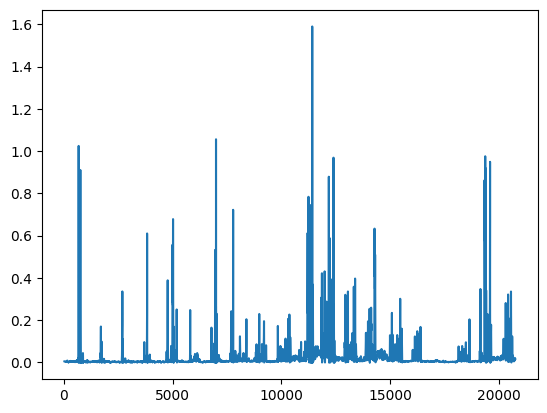

In [4]:
import matplotlib.pyplot as plt

plt.plot(gui.data_manager.dict_Fall["pri"]["cascade_spike_prob"][0])

In [3]:
from optic.processing.cascade import runCascade

spike_prob, spike_events = runCascade(
    traces=traces,
    model_name=model_name
)

Pretrained model was saved in folder "d:\optic\external\cascade\Pretrained_models\Global_EXC_30Hz_smoothing25ms_causalkernel"

 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 25 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 80 neurons and 20769 frames.
Noise levels (mean, std; in standard units): 0.21, 0.06

Predictions for noise level 2:
	... ensemble 0
1623/1623 [==============================] - 4s 1ms/step
	... ensemble 1
1623/1623 [==============================] - 1s 815us/step
	... ensemble 2
1623/1623 [==============================] - 1s 854us/step
	... ensemble 3
1623/1623 [==============================] - 2s 1ms/step
	... ensemble 4
1623/1623 [==============================] - 2s 898us/step

Predictions for noise level 3:
	No neurons for this noise level

Prediction

In [3]:
yaml_file = open(f'{dir_cascade}/Pretrained_models/available_models.yaml')

In [4]:
yaml_models = yaml.load(yaml_file)

AttributeError: 
"load()" has been removed, use

  yaml = YAML(typ='rt')
  yaml.load(...)

and register any classes that you use, or check the tag attribute on the loaded data,
instead of file "C:\Users\HyperPC_Smee\AppData\Local\Temp\ipykernel_28888\2598747735.py", line 1

yaml_models = yaml.load(yaml_file)



In [5]:
sys.path.append(dir_external)

In [6]:
from cascade.cascade2p import cascade

In [9]:
import ruamel.yaml as yaml
yaml = yaml.YAML(typ='rt')

yaml_file = open(f'{dir_cascade}/Pretrained_models/available_models.yaml')
yaml_models = yaml.load(yaml_file)
list_of_models = list(yaml_models.keys())

In [11]:
len(list_of_models)

155

In [4]:
gui.widget_manager.dict_checkbox["light_plot_mode"].isChecked()

False

In [23]:
gui.control_manager.canvas_controls["pri"].full_traces["F"].shape

(20769,)

In [4]:
gui.data_manager.dict_Fall

{'pri': {'F': array([[-0.15288106, -0.15288106, -0.15288106, ...,  0.17165933,
           0.17165933,  0.17165933],
         [-0.14068846, -0.14068846, -0.14068846, ...,  0.30399535,
           0.30399535,  0.30399535],
         [ 0.16551903,  0.16551903,  0.16551903, ...,  0.02346825,
           0.02346825,  0.02346825],
         ...,
         [-0.0103093 , -0.0103093 , -0.0103093 , ...,  0.05224901,
           0.05224901,  0.05224901],
         [-0.05377314, -0.05377314, -0.05377314, ...,  0.08722159,
           0.08722159,  0.08722159],
         [-0.0216071 , -0.0216071 , -0.0216071 , ...,  0.00108031,
           0.00108031,  0.00108031]]),
  'ops': {'nchannels': 1, 'fs': 1}}}

In [10]:
gui.data_manager.dict_Fall["pri"]["F"].shape

(80, 20769)

In [8]:
gui.data_manager.getDataType("pri")

'.mat'

In [8]:
gui.widget_manager.dict_button

{}

In [5]:
gui.control_manager.table_controls[gui.app_key_pri].len_row

2697